# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gdown 'https://drive.google.com/uc?id=1pu_DDikwPzkysc8F0S-hko0k4Il1P7p_'

Downloading...
From: https://drive.google.com/uc?id=1pu_DDikwPzkysc8F0S-hko0k4Il1P7p_
To: /content/flickr.zip
1.11GB [00:07, 149MB/s] 


In [ ]:
!unzip flickr.zip

# Data

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import os
import random
import sys

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
#%load_ext tensorboard.notebook

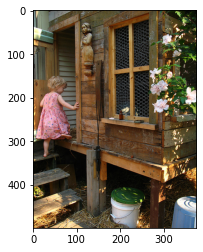

In [2]:
img = image.load_img('flickr/images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
plt.imshow(img)

In [3]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
h, w = x.shape[1:3]
print(h, w)

500 375


In [4]:
import os
from tensorflow.keras.utils import Sequence

# Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to LAB. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

class DataGenerator2D(Sequence):
    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):
        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(base_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id)/float(self.batch_size)))

    def __load__(self, id_name):
        image_path  = os.path.join(self.base_path, id_name)

        img = image.load_img(image_path, target_size=(self.img_size, self.img_size))
        img = image.img_to_array(img)
        lab = rgb2lab(img / 255.0)

        input_image = lab[:,:,0]
        # L channel(grayscale)
        output_image = (lab[:,:,1:] / 128)
        # A and B channels(colour information)

        input_image = np.array(input_image)
        output_image = np.array(output_image)

        input_image = input_image.reshape(input_image.shape+(1,))
        # converts (256, 256) -> (256, 256, 1)

        return input_image, output_image


    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.id):
            file_batch = self.id[index*self.batch_size:]
        else:
            file_batch = self.id[index*self.batch_size:(index+1)*self.batch_size]
        
        bw_images, colour_images = [], []

        for id_name in file_batch:
            bw_img, color_img = self.__load__(id_name)
            bw_images.append(bw_img)
            colour_images.append(color_img)

        bw_images = np.array(bw_images)
        colour_images  = np.array(colour_images)

        return bw_images, colour_images


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [5]:
train_generator = DataGenerator2D('flickr/images/Flicker8k_Dataset/', img_size=256, batch_size=64, shuffle=True)

In [6]:
X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(64, 256, 256, 1) (64, 256, 256, 2)


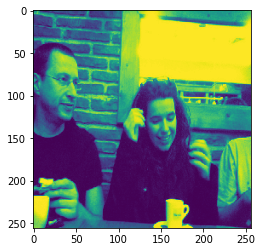

In [7]:
# L channel
plt.imshow(X[0].reshape(256, 256))

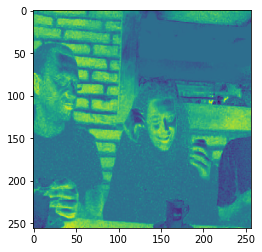

In [8]:
# A channel
plt.imshow(y[0,:,:,0])

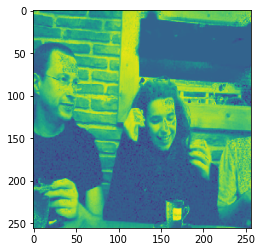

In [9]:
# B channel
plt.imshow(y[0,:,:,1])

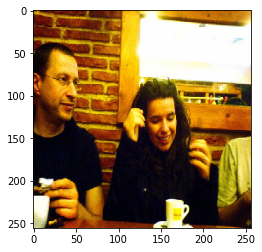

In [10]:
# Rebuilt image
y = y*128
result = np.zeros((256, 256, 3))
result[:,:,0] = X[0][:,:,0]
result[:,:,1:] = y[0]
plt.imshow(lab2rgb(result))

# Model

In [11]:
def unet(sz = (256, 256, 1)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    layers.append(x)
    x = MaxPooling2D() (x)
    x = BatchNormalization()(x)
    f = f*2
  ff2 = 64
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = BatchNormalization()(x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = BatchNormalization()(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  outputs = Conv2D(2, 1, activation='sigmoid') (x)
  # outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

model = unet()

model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/models/image-colorization/" + "U-Net-" + "epoch-{epoch:02d}-loss-{loss:.6f}.hdf5",
                                                 verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=125,
                    callbacks=[cp_callback],
                    epochs = 100,
                    verbose=1)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.5818
Epoch 00001: saving model to drive/My Drive/models/image-colorization/U-Net-epoch-01-loss-0.177689.hdf5
125/125 [==============================] - 171s 1s/step - loss: 0.1777 - accuracy: 0.5818
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.5717
Epoch 00002: saving model to drive/My Drive/models/image-colorization/U-Net-epoch-02-loss-0.071630.hdf5
125/125 [==============================] - 172s 1s/step - loss: 0.0716 - accuracy: 0.5717
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.5446
Epoch 00003: saving model to drive/My Drive/models/image-colorization/U-Net-epoch-03-loss-0.028844.hdf5
125/125 [==============================] - 172s 1s/step - loss: 0.0288 - accuracy: 0.5446
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.5766
Epoch 00004: saving model to d

(1, 256, 256, 3)
(1, 256, 256)
(1, 256, 256, 1)


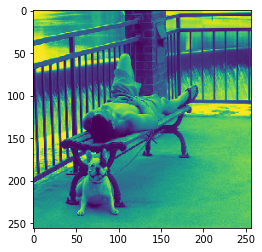

In [13]:
# model = tf.keras.models.load_model("drive/My Drive/models/image-colorization/Autoencoder100.hdf5")

img_color = []

img = image.img_to_array(image.load_img('flickr/images/Flicker8k_Dataset/1003163366_44323f5815.jpg', target_size=(256,256)))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
print(img_color.shape)
img_color = rgb2lab(img_color/255.0)[:,:,:,0]
print(img_color.shape)
img_color = img_color.reshape(img_color.shape+(1,))
print(img_color.shape)

plt.imshow(rgb2lab(img/255.0)[:,:,0])

In [14]:
output = model.predict(img_color)
output.shape

(1, 256, 256, 2)

In [15]:
output = output*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]
result.shape

(256, 256, 3)

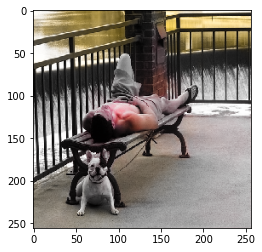

In [16]:
plt.imshow(lab2rgb(result))

# Reconstructed Models

In [17]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import os
import random
import sys

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
#%load_ext tensorboard.notebook

In [18]:
reconstructed_model = tf.keras.models.load_model("drive/My Drive/models/image-colorization/U-Net/U-Net-epoch-95-loss-0.006184.hdf5")

(1, 256, 256, 3)
(1, 256, 256)
(1, 256, 256, 1)


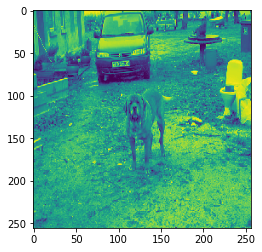

In [19]:
img_color = []

img = image.img_to_array(image.load_img('flickr/images/Flicker8k_Dataset/2098418613_85a0c9afea.jpg', target_size=(256,256)))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
print(img_color.shape)
img_color = rgb2lab(img_color/255.0)[:,:,:,0]
print(img_color.shape)
img_color = img_color.reshape(img_color.shape+(1,))
print(img_color.shape)

plt.imshow(rgb2lab(img/255.0)[:,:,0])

In [20]:
output = reconstructed_model.predict(img_color)
output.shape

(1, 256, 256, 2)

In [21]:
output = output*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]
result.shape

(256, 256, 3)

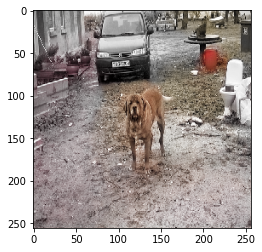

In [22]:
plt.imshow(lab2rgb(result))